# REALTIME-PROCESS-DETECTION (Notebook Version)

This notebook is an adaptation of the real-time gesture and pose detection system using MediaPipe Holistic, designed for gesture recognition tasks such as sign language detection. It extracts only the upper body pose landmarks (0–16) and both hand landmarks, referenced to the shoulder center, and scaled by shoulder width.

The system outputs normalized (x, y) coordinates as a unified feature vector, suitable for visualization, logging, or training gesture classification models.


In [1]:
# Import necessary libraries
import cv2 as opencv
import mediapipe as mp
import math
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display, clear_output


## Helper Functions
These functions are used to calculate shoulder width, normalize landmarks, and visualize the results.

In [2]:
def euclidean_distance(a, b):
    return math.hypot(a.x - b.x, a.y - b.y)

def normalize_landmarks(landmarks, center, scale):
    return [((lm.x - center[0]) / scale, (lm.y - center[1]) / scale) for lm in landmarks]

def draw_landmark_scatter(pose_points, right_hand=None, left_hand=None):
    plt.figure(figsize=(6, 6))
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='gray', linestyle='--')
    if pose_points:
        px, py = zip(*pose_points)
        plt.scatter(px, py, c='blue', label='Pose')
    if right_hand:
        rx, ry = zip(*right_hand)
        plt.scatter(rx, ry, c='green', label='Right Hand')
    if left_hand:
        lx, ly = zip(*left_hand)
        plt.scatter(lx, ly, c='red', label='Left Hand')
    plt.gca().invert_yaxis()
    plt.legend()
    plt.title('Normalized Pose + Hand Landmarks')
    plt.grid(True)
    plt.show()


## Capture and Process a Single Frame
This section runs MediaPipe Holistic on a single frame from webcam input. Adjust the code if you want to iterate or use video input instead.

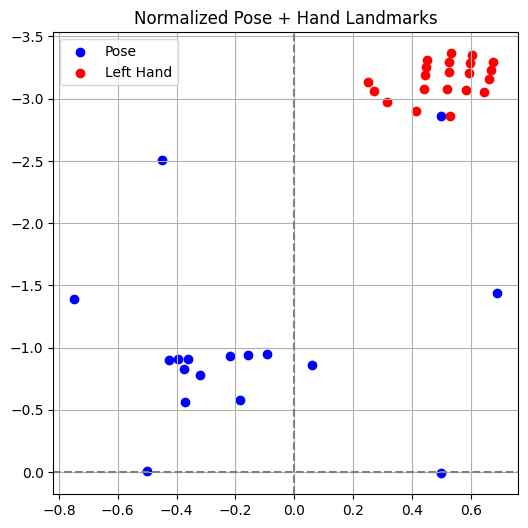

In [4]:
mp_holistic = mp.solutions.holistic
cap = opencv.VideoCapture(0)
holistic = mp_holistic.Holistic(static_image_mode=False)

ret, frame = cap.read()
if ret:
    frame = opencv.flip(frame, 1)
    rgb = opencv.cvtColor(frame, opencv.COLOR_BGR2RGB)
    results = holistic.process(rgb)
    
    if results.pose_landmarks:
        pose_lm = results.pose_landmarks.landmark[:17]
        left_shoulder = results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_SHOULDER]
        right_shoulder = results.pose_landmarks.landmark[mp_holistic.PoseLandmark.RIGHT_SHOULDER]
        shoulder_center = ((left_shoulder.x + right_shoulder.x) / 2, (left_shoulder.y + right_shoulder.y) / 2)
        shoulder_width = euclidean_distance(left_shoulder, right_shoulder)

        norm_pose = normalize_landmarks(pose_lm, shoulder_center, shoulder_width)

        norm_right = normalize_landmarks(results.right_hand_landmarks.landmark, shoulder_center, shoulder_width) if results.right_hand_landmarks else None
        norm_left = normalize_landmarks(results.left_hand_landmarks.landmark, shoulder_center, shoulder_width) if results.left_hand_landmarks else None

        draw_landmark_scatter(norm_pose, norm_right, norm_left)
    else:
        print("Pose not detected.")

cap.release()
opencv.destroyAllWindows()
holistic.close()